<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Workshop_extra/Jupyter-notebooks/regression-curvefitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear and Nonlinear Regression
(adapted from CHEM 1000 - Spring 2023 Prof. Geoffrey Hutchison, University of Pittsburgh)

By the end of this session, you should be able to:
- Understand nonlinear regression through *transforms*
- Understand "robust regression" (to ignore outliers)

We'll cover a few examples in recitation as well, particularly `curve_fit` and getting the standard errors in our fit parameters.

## Linear (and Nonlinear) Regression

Probably all of you have fit a trendline through a set of data in Excel or another program:

$$
y = mx + b; R^2 = ...
$$

There are assumptions behind linear regression:

- **Linearity**: the relationship between X and Y is linear.
- **Independence**: observations are independent of each other (e.g., it's not a time series)
- **Homoscedasticity**: the residual errors do not depend on X
- **Normality**: the residual errors are normally distributed

It's fairly easy to use some diagnostic plots to test these assumptions, particularly:
- looking at the observed Y values versus the fitted values
- looking at the residual errors as a function of X values

We'll talk about the assumptions and what to do if they don't hold up later.

There are several packages in Python that can (and will) do curve fitting - each has somewhat different features:
- statsmodels
- scipy
- scikit-learn

We're going to use `scipy.stats.linregress()` for linear regression and `scipy.optimize.curve_fit()` for general curve fitting.

In [1]:
# Let's plot it!
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('./chem1000.mplstyle')

### Tips Data

This is a somewhat famous data set:
Bryant, P. G. and Smith, M (1995) *Practical Data Analysis: Case Studies in Business Statistics.* Homewood, IL: Richard D. Irwin Publishing

Each tip recorded at a restaurant over 244 bills.

In [2]:
import pandas as pd # to read spreadsheets like CSV

tips_data = pd.read_csv('./data/tips.csv')
tips_data.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [3]:
tips_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Okay, we see the total bill in \\$ and the tip in \\$ as well, along with who paid the bills, whether anyone smoked (it's back from when you could smoke in restaurants), mealtime, and size of the table.

Let's see how the tip scales with the total bill.

Text(0, 0.5, 'Tip ($)')

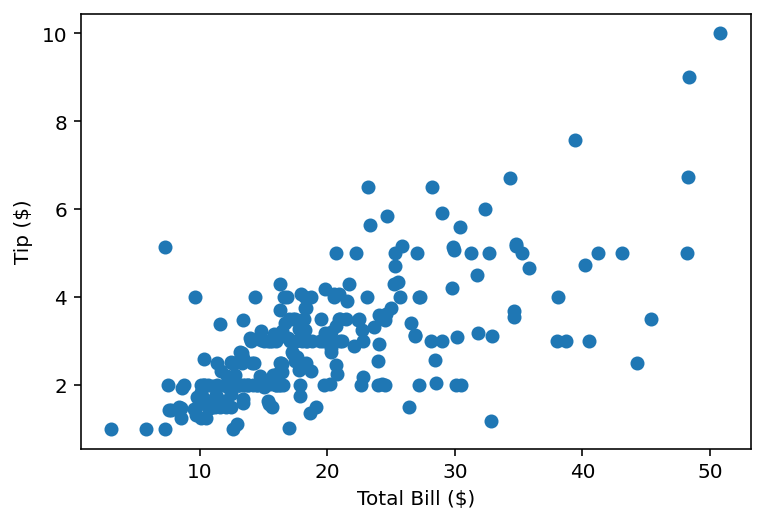

In [4]:
plt.scatter(tips_data.total_bill, tips_data.tip)
plt.xlabel('Total Bill ($)')
plt.ylabel('Tip ($)')

This is a classic case of heteroscedastic errors - much larger variation with big bills than with small bills because people generally pay as a percentage...

<AxesSubplot: xlabel='day', ylabel='tip'>

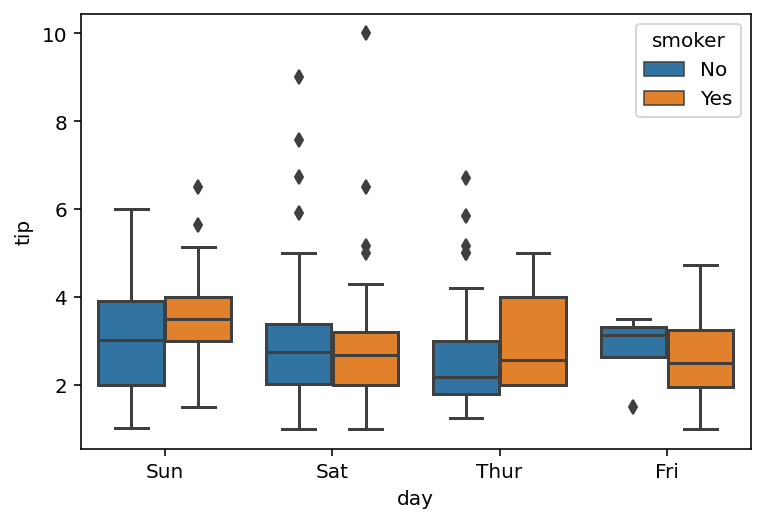

In [5]:
# seaborn is a Python package on top of matplotlib - it makes some plots much easier
#    https://seaborn.pydata.org/examples/index.html
import seaborn as sns

# Draw a nested boxplot to show tips by day
sns.boxplot(x="day", y="tip", hue="smoker", data=tips_data)

Notice the outliers in the box plots. Not sure how much data there is, but the median tip from a smoker on Sunday seems higher...

The catch, though, is that we *know* tips are related to total bill. Most people tip around 15%.

So let's *transform* the data and see if we can minimize the heteroscedastic errors.

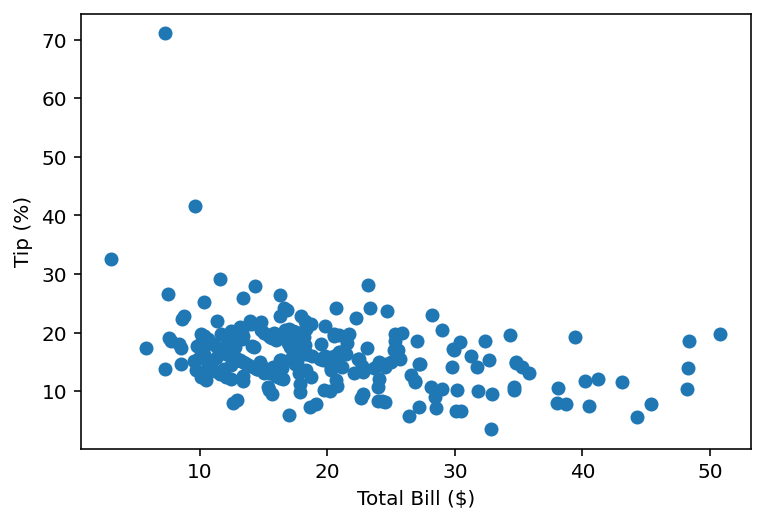

In [6]:
# I don't need to do this, but it saves me some typing
tips = tips_data.tip
total_bill = tips_data.total_bill

percent = tips / total_bill

plt.scatter(total_bill, percent * 100)
plt.xlabel('Total Bill ($)')
plt.ylabel('Tip (%)')
plt.show()

Woah, that's a nice tip! Let's analyze the cases where the tip is under 30% (i.e., the usual cases)

In [7]:
clean = tips_data[percent < 0.3]

percent = clean['tip']*100 / clean['total_bill']
print(percent)

0       5.944673
1      16.054159
2      16.658734
3      13.978041
4      14.680765
         ...    
239    20.392697
240     7.358352
241     8.822232
242     9.820426
243    15.974441
Length: 241, dtype: float64


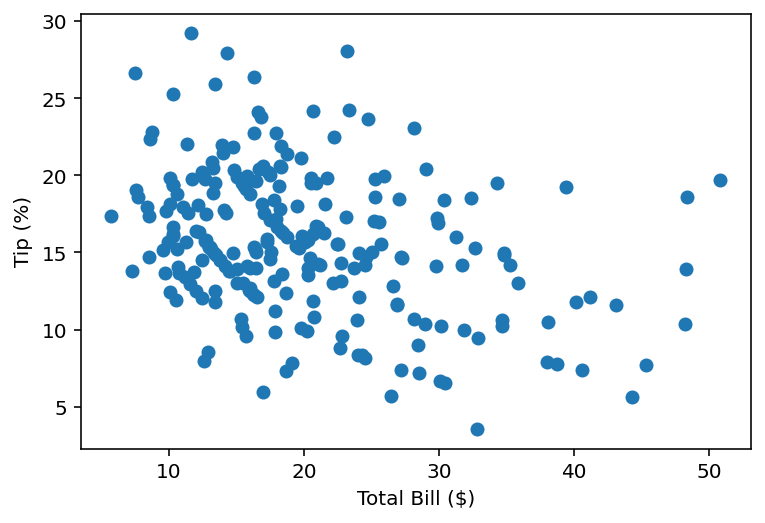

In [8]:
plt.scatter(clean['total_bill'], percent)
plt.xlabel('Total Bill ($)')
plt.ylabel('Tip (%)')
plt.show()

It's safe to say that smaller restaurant bills get higher tips.. and some people are really, really bad tippers in this data set. I mean 5% tip? That's horrible!

It's still not linear.

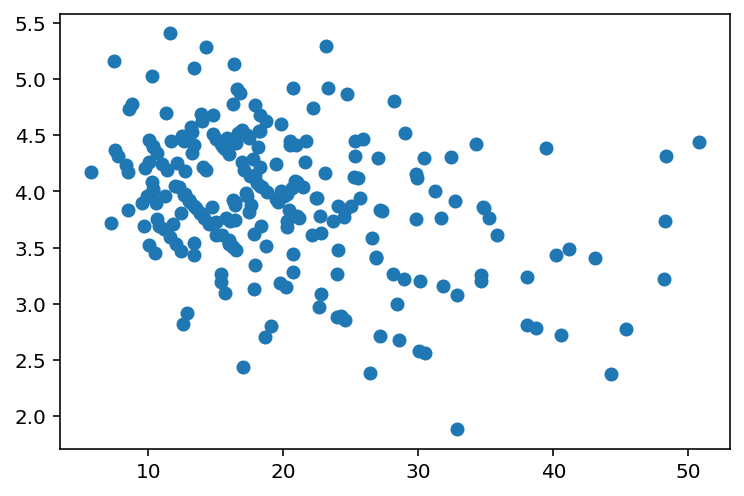

In [9]:
plt.scatter(clean['total_bill'], np.sqrt(percent))

You can feel free to play with the data more... transforming the X or Y values to get a better fit.

Sometimes in science we **know** the functional form. In that case, either transform the data or use `curve_fit` with an exact function.

Sometimes we don't know the functional form. So we want a fairly good empirical fit.

This is sometimes known as the ladder of transforms (e.g., things to try):

* Exponential $e^x$
* Square / Cube $x**2$
* **Original Data**
* Square Root $\sqrt{x}$
* Logarithm $\log(x)$
* Reciprocal Root $1/\sqrt{x}$
* Reciprocal $1/x$
* etc.



## Multiple Regression

Sometimes data needs to be fit from more than one variable. Consider the fuel efficiency of a car. It depends on the mass of the car, the volume of the engine, the type of engine (V8, V6, etc.), …

Let's consider the tip data further. After all, there's a lot of scatter to the data. Should we consider the size of the party? What if small tables with a big bill tip better (e.g., a date)?

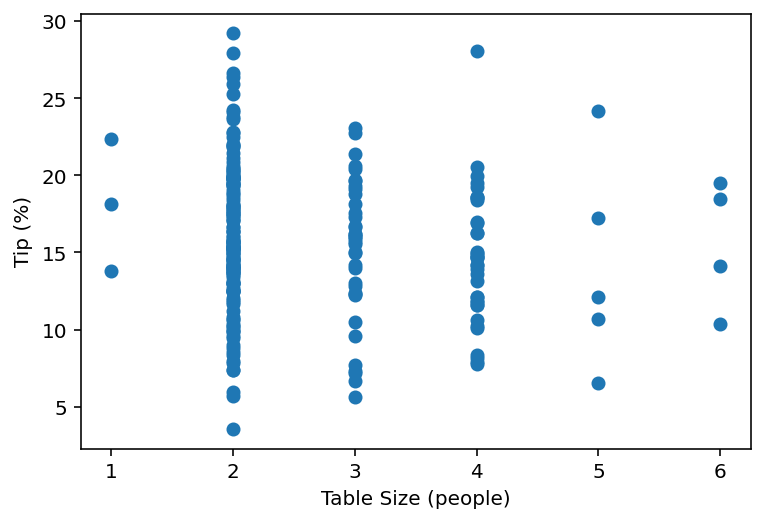

In [10]:
plt.scatter(clean['size'], percent)
plt.xlabel('Table Size (people)')
plt.ylabel('Tip (%)')
plt.show()

Hmm. Seems like there are some *very* cheap 2-person tables .. maybe there's an overall effect? It's hard to know since this is probably correlated with the total bill too.

We can use the `statsmodels` Python package for multi-variate fits.

Particularly the `statsmodels.formula.api` or `smf` component lets us use a syntax:

`percent ~ total_bill + size`

This is an `ols` or Ordinary Least Squares model:
* Intercept
* Coefficient * total_bill
* Coefficient * size

Statsmodels also gives us some nice summaries.

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('percent ~ total_bill + size', data=clean).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     15.97
Date:                Tue, 07 Feb 2023   Prob (F-statistic):           3.12e-07
Time:                        14:12:21   Log-Likelihood:                -694.06
No. Observations:                 241   AIC:                             1394.
Df Residuals:                     238   BIC:                             1405.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.4070      0.841     21.881      0.0

There's a **lot** in that summary:

- $R^2$ is only 0.118. Meh.
- Adjusted $R^2$ "adjusts" for the degrees of freedom - subtracting for each parameter
- Values of the parameters and also standard errors (e.g., 18.407 ± 0.841)
- P-values
- Skew and kurtosis
- etc. (there's a lot .. you don't need to understand it all)

We can see that the total bill is a *negative* influence on the tip, but party size *might* be a slightly positive counter-effect. (Although if you look at the data, we can see that this place didn't have a minimum tip for large groups .. there's a 6-person table with 10\% tip...)

## Model Validation - Entropy

When you have enough data, it's important to *cross-validate* your model. There are a few ways to do this. The most common is to split your data into a set for training the model and another set for validation / testing.

For example, maybe the model you fit only works for certain kinds of molecules?

Here's some example data from a recent paper ["Understanding conformational entropy in small molecules"](https://doi.org/10.1021/acs.jctc.0c01213) - we're trying to understand how the entropy of a molecule depends on multiple conformations. For example, we suspect it might depend on the number of rotatable bonds.

In [14]:
# training our model
train_df = pd.read_csv("./data/train.csv")
# test data
test_df = pd.read_csv("./data/holdout.csv")

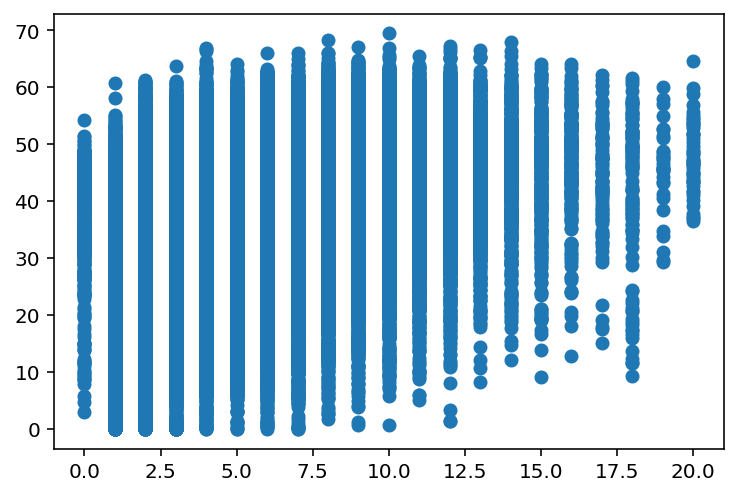

In [15]:
plt.scatter(train_df['NumRotors'], train_df['ConfEntropy'])

Hmm. Maybe it connects? (Yes) Maybe we should plot other variables.

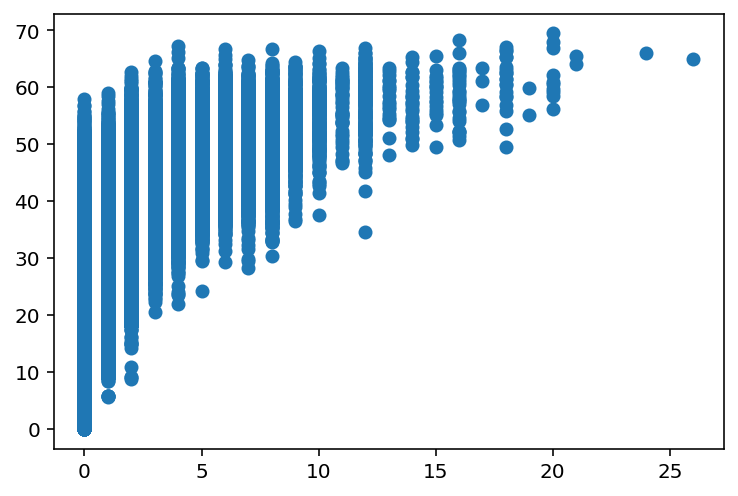

In [16]:
plt.scatter(train_df['NumMethyl'], train_df['ConfEntropy'])

So the number of methyl groups *definitely* connects with our conformational entropy. But probably not linearly.

In [17]:
results = smf.ols('ConfEntropy ~ NumMethyl', data=train_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                 1.054e+05
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:13:09   Log-Likelihood:            -3.2997e+05
No. Observations:               93021   AIC:                         6.599e+05
Df Residuals:                   93019   BIC:                         6.600e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.2101      0.041    621.912      0.0

In [18]:
results = smf.ols('ConfEntropy ~ np.log(NumMethyl+1)', data=train_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.443e+05
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:13:15   Log-Likelihood:            -3.2165e+05
No. Observations:               93021   AIC:                         6.433e+05
Df Residuals:                   93019   BIC:                         6.433e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                20.49

Notice that our model increased to an $R^2 = 0.608$ with $\log(\mathrm{NumMethyl} + 1)$.

Let's try adding in $\log(\mathrm{NumRotors} + 1)$ too:

In [19]:
results = smf.ols('ConfEntropy ~ np.log(NumMethyl+1) + np.log(NumRotors+1)', data=train_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            ConfEntropy   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                 1.061e+05
Date:                Tue, 07 Feb 2023   Prob (F-statistic):               0.00
Time:                        14:13:21   Log-Likelihood:            -3.0994e+05
No. Observations:               93021   AIC:                         6.199e+05
Df Residuals:                   93018   BIC:                         6.199e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 9.49

Nice! We can see that `statsmodels` can handle both transforming our data as well as multiple regression.

We should *really* plot the residuals to check our assumptions, but I leave that as an exercise.

(As it turns out the residuals aren't great .. so we did more work in the paper .. the main contributions are still from these two effects.)

## Robust Regression

One of the challenges with regression is that it can be strongly affected by outlier points, much like the mean average.

We're going to create some artificial data with outliers to show this more clearly.

In [20]:
# This is from the statsmodel website - don't worry.. just creating some artificial data with an outlier

# y = 5 + 0.5x

nsample = 50
x1 = np.linspace(0, 20, nsample) # from 0 to 20 with 50 points
X = x1
X = sm.add_constant(X)

# Now we create our y values
beta = [5, 0.5]
y_true2 = np.dot(X, beta)  # y = 5 + 0.5x

# Add some random noise
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)

# Now add some outliers
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

Okay, let's try to fit a quadratic function to this data.

OLS = ordinary least squares (i.e., normal regression)
RLM = robust linear model (i.e., ignore outliers)

In [21]:
res = sm.OLS(y2, X).fit()
print(res.params)

[5.67008568 0.38608185]


Okay, that's $y = 5.589 + 0.391x$

In [22]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)

[5.15799906 0.47927037]


Notice that we're much closer to the real function $y = 5.07 + 0.487x$

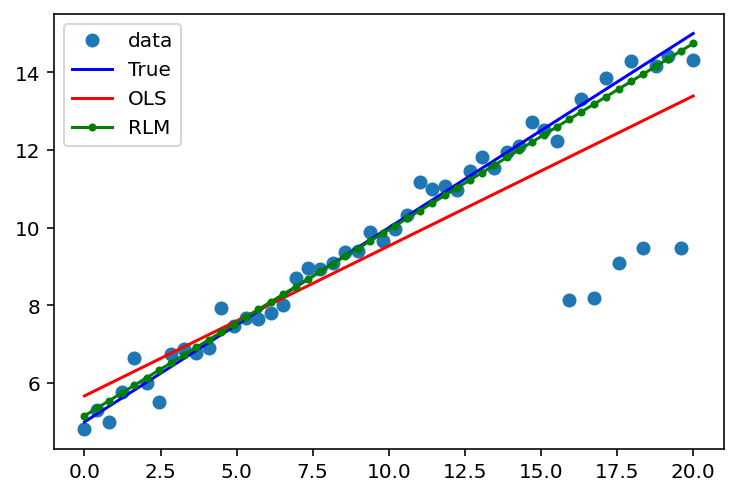

In [23]:
plt.plot(x1, y2, "o", label="data")
plt.plot(x1, y_true2, "b-", label="True")

plt.plot(x1, res.fittedvalues, "r-", label="OLS")
plt.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
plt.legend(loc="best")

Notice that the outliers "pull" the linear regression to a lower slope and higher intercept, but the robust regression method ignores them.

-------
This notebook is adapted from Prof. Geoffrey Hutchison, University of Pittsburgh
https://github.com/ghutchis/chem1000

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>